### **Object detection for artefacts in documents**

In this notebook, we will explore how to use a popular object detection architecture, [Faster-RCNN](https://arxiv.org/abs/1506.01497), to detect QR codes, bar codes, logos and ID pictures in documents.

Faster R-CNN is an end-to-end architecture, which leverages a dedicated module to generate region proposals (considerably more efficient than traditional algorithms like Selective Search). The features of those localization candidates are then extracted by an ROI Pooling layer to produce fixed-size feature maps from each candidate. The network can accurately and quickly predict the locations of different objects. Please refer to [Faster R-CNN Explained for Object Detection Tasks](https://blog.paperspace.com/faster-r-cnn-explained-object-detection/) for a quick introduction.


## Setup
Installing requirements

In [1]:
!pip3 install git+https://github.com/mindee/doctr.git

  Created wheel for python-doctr: filename=python_doctr-0.5.0a0-py3-none-any.whl size=190837 sha256=e8196df66ae87393ecce6469d57b49eb9c52d74b9cb2ea90fabc663aa8a0a7e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7nd5raad/wheels/d0/0b/ff/7a8340c456681155118f4537b617ee1af015814b8b51f53c11
  Created wheel for mplcursors: filename=mplcursors-0.5.1-py3-none-any.whl size=20810 sha256=b30d711e43d8860bae2504734127fc1de3d33c3ebbd9308a51145ea20e4c270d
  Stored in directory: /root/.cache/pip/wheels/ae/cd/13/09fe660e3e9d392c7e9b46f202369cd9c2b8dddfb47d5950ef
  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89667 sha256=25695f0b2ce4d4ed1ccbef5e376b6565fee0ce965fed529a31d06baebb530319
  Stored in directory: /root/.cache/pip/wheels/4e/ca/e1/5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built python-doctr mplcursors cairocffi
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully u

## Inference utilities
Import all dependencies at once 

In [1]:
import os

os.environ['USE_TORCH'] = '1'

import argparse
import logging

import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import torch

from doctr.io.image import read_img_as_tensor
from doctr.models import obj_detection

# Detected classes
CLASSES = ["__background__", "QR Code", "Barcode", "Logo", "Photo"]
# Color map for each class
CM = [(255, 255, 255), (0, 0, 150), (0, 0, 0), (0, 150, 0), (150, 0, 0)]

Everything you need to plot your model's predictions

In [2]:
# Plots the predictions on the input image
def plot_predictions(image, boxes, labels):
    for box, label in zip(boxes, labels):
        # Bounding box around artefacts
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]),
                      CM[label], 2)
        text_size, _ = cv2.getTextSize(CLASSES[label], cv2.FONT_HERSHEY_SIMPLEX, 2, 2)
        text_w, text_h = text_size
        # Filled rectangle above bounding box
        cv2.rectangle(image, (box[0], box[1]), (box[0] + text_w, box[1] - text_h),
                      CM[label], -1)
        # Text bearing the name of the artefact detected
        cv2.putText(image, CLASSES[label], (int(box[0]), int(box[1])),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 3)
    figure(figsize=(10, 8), dpi=90)
    plt.axis('off')
    plt.imshow(image)
    plt.show()


## Visualizing your detections
`img_path: str` >> path to image file


--2021-12-24 16:20:33--  https://images.sampletemplates.com/wp-content/uploads/2018/04/Car-Parking-Receipt-Template.jpg
Resolving images.sampletemplates.com (images.sampletemplates.com)... 151.101.2.133, 151.101.66.133, 151.101.130.133, ...
Connecting to images.sampletemplates.com (images.sampletemplates.com)|151.101.2.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68765 (67K) [image/jpeg]
Saving to: ‘Car-Parking-Receipt-Template.jpg’

Car-Parking-Receipt 100%[===================>]  67.15K  --.-KB/s    in 0.005s  

2021-12-24 16:20:33 (12.8 MB/s) - ‘Car-Parking-Receipt-Template.jpg’ saved [68765/68765]



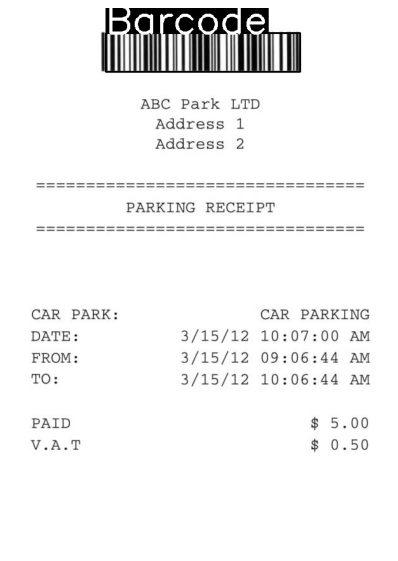

In [16]:
# Initializing the model fasterrcnn_mobilenet_v3_large_fpn
model = obj_detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, num_classes=5).eval()
# Path to input image file
!wget https://images.sampletemplates.com/wp-content/uploads/2018/04/Car-Parking-Receipt-Template.jpg
img_path = "Car-Parking-Receipt-Template.jpg"
# Reading the input image
img = read_img_as_tensor(img_path).unsqueeze(0)

if torch.cuda.is_available():
    model = model.cuda()
    img = img.cuda()

with torch.no_grad():
    pred = model(img)

labels = pred[0]['labels'].detach().cpu().numpy()
labels = labels.round().astype(int)
boxes = pred[0]['boxes'].detach().cpu().numpy()
boxes = boxes.round().astype(int)
img = img.cpu().permute(0, 2, 3, 1).numpy()[0].copy()
plot_predictions(img, boxes, labels)